In [1]:
# Importing packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from functools import reduce
from collections import defaultdict
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.cross_decomposition import PLSSVD
from sklearn.compose import ColumnTransformer

# displaying all the rows and columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# setting random seed:
RANDOM_SEED = 42

## 1. EDA

In [2]:
# Load the data:
data = pd.read_csv('/Users/bangxixiao/Desktop/python_projects/DATA1030_MIDTERM_PROJECT/data/application_data.csv', 
                   encoding='UTF-8')

In [3]:
print('The credit default data has {} rows and {} columns.'.format(data.shape[0], data.shape[1]))

The credit default data has 307511 rows and 122 columns.


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


The data has 307511 entries and 122 columns, where 65 columns are identified as float, 41 columns as integer and 16 columns as object (string).

In [5]:
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

We noticed that there exists a small proportion of missing data.

In [6]:
# describe the data:
data.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399,0.008809,0.028358,0.114231,0.087543,0.977065,0.759637,0.042553,0.074490,0.145193,0.222315,0.228058,0.064958,0.105645,0.105975,0.008076,0.027022,0.117850,0.087955,0.97

The columns could be separated into different categories by looking at the prefix of column names:

AMT: data related to specific numbers such as loan annuity, annuity of previous application and so on.

APARTMENTS: apartment-related information

BASEMENTAREA: basement information about building where the clients live

CHANEL: Through which channel we acquired the client on the previous application

CNT: count data such the number of children the client has

CODE: includes gender and why previous application rejected

COMMONAREA: common area information about building where the clients live

DAYS: includes date-related information such as birth, employment

DEF: clients' social surroundings count

ELEVATORS: living condition of clients

EMERGENCYSTATE: living condition of clients

ENTRANCES: living condition of clients

EXT: normalized score from external data source

FLAG: consists of bool values

FLOORSMAX/FLOORSMIN: living condition of clients

HOUR: data regarding the time, for example, the exact hour the client apply for the loan

LANDAREA: living condition of the clients

LIVE: if the client's contact address match with the work address

LIVINGAPARTMENTS/LIVINGAREA: living condition of clients

NAME: mostly strings data regarding the client's personal information

NFLAG: bool-like data

NONLIVINGAPARTMENT/NONLIVINGAREA: living condition of the clients

OBS: number of observations of clients' social surroundings

OCCUPATION: kind of occupation client has

ORGANIZATION: type of organization where client works

OWN: age of client's car

PRODUCT: detailed product combination of the previous application

RATE: fractional number

REG: bool type data, regarding the match of client's permanent address

SELLERPLACE: selling area of seller place of the previous application

SK_: ID-like data

TARGET: target variable

TOTALAREA: living condition of client

WALLSMATERIAL: living condition of client

WEEKDAY: which day in a week the client applies for a loan

YEARS: living condition of client

In [8]:
# classify columns to different fields mentioned above:
def get_columns_collection(d):
    col_prefix = [x.split('_')[0] for x in d.columns]
    col_collection = defaultdict(list)
    for cp, c in zip(col_prefix, d.columns):
        col_collection[cp].append(c)
    return col_collection

In [9]:
# investigating the missing values:
data.isnull().sum().sort_values(ascending=False)

COMMONAREA_MEDI                 214865
COMMONAREA_AVG                  214865
COMMONAREA_MODE                 214865
NONLIVINGAPARTMENTS_MODE        213514
NONLIVINGAPARTMENTS_AVG         213514
NONLIVINGAPARTMENTS_MEDI        213514
FONDKAPREMONT_MODE              210295
LIVINGAPARTMENTS_MODE           210199
LIVINGAPARTMENTS_AVG            210199
LIVINGAPARTMENTS_MEDI           210199
FLOORSMIN_AVG                   208642
FLOORSMIN_MODE                  208642
FLOORSMIN_MEDI                  208642
YEARS_BUILD_MEDI                204488
YEARS_BUILD_MODE                204488
YEARS_BUILD_AVG                 204488
OWN_CAR_AGE                     202929
LANDAREA_MEDI                   182590
LANDAREA_MODE                   182590
LANDAREA_AVG                    182590
BASEMENTAREA_MEDI               179943
BASEMENTAREA_AVG                179943
BASEMENTAREA_MODE               179943
EXT_SOURCE_1                    173378
NONLIVINGAREA_MODE              169682
NONLIVINGAREA_AVG        

In [9]:
# percentage of missing:
(data.isnull().sum()/len(data)*100).sort_values(ascending=False)

COMMONAREA_MEDI                 69.872297
COMMONAREA_AVG                  69.872297
COMMONAREA_MODE                 69.872297
NONLIVINGAPARTMENTS_MODE        69.432963
NONLIVINGAPARTMENTS_AVG         69.432963
NONLIVINGAPARTMENTS_MEDI        69.432963
FONDKAPREMONT_MODE              68.386172
LIVINGAPARTMENTS_MODE           68.354953
LIVINGAPARTMENTS_AVG            68.354953
LIVINGAPARTMENTS_MEDI           68.354953
FLOORSMIN_AVG                   67.848630
FLOORSMIN_MODE                  67.848630
FLOORSMIN_MEDI                  67.848630
YEARS_BUILD_MEDI                66.497784
YEARS_BUILD_MODE                66.497784
YEARS_BUILD_AVG                 66.497784
OWN_CAR_AGE                     65.990810
LANDAREA_MEDI                   59.376738
LANDAREA_MODE                   59.376738
LANDAREA_AVG                    59.376738
BASEMENTAREA_MEDI               58.515956
BASEMENTAREA_AVG                58.515956
BASEMENTAREA_MODE               58.515956
EXT_SOURCE_1                    56

Noticed that we have multiple columns having their missing proportions greater than 0; to deal with, we directly remove the features that have missing values greater than a half. For the features that have missing proportions between 0.0% and 50.0%, we will examine them one by one and decide whether to keep (do some imputation) or delete. 

In [10]:
data_drop_missing = data.loc[:, data.isnull().sum()/len(data) < 0.50]

The resulting data:

In [11]:
(data_drop_missing.isnull().sum()/len(data)*100).sort_values(ascending=False)

FLOORSMAX_AVG                   49.760822
FLOORSMAX_MODE                  49.760822
FLOORSMAX_MEDI                  49.760822
YEARS_BEGINEXPLUATATION_AVG     48.781019
YEARS_BEGINEXPLUATATION_MODE    48.781019
YEARS_BEGINEXPLUATATION_MEDI    48.781019
TOTALAREA_MODE                  48.268517
EMERGENCYSTATE_MODE             47.398304
OCCUPATION_TYPE                 31.345545
EXT_SOURCE_3                    19.825307
AMT_REQ_CREDIT_BUREAU_YEAR      13.501631
AMT_REQ_CREDIT_BUREAU_HOUR      13.501631
AMT_REQ_CREDIT_BUREAU_DAY       13.501631
AMT_REQ_CREDIT_BUREAU_WEEK      13.501631
AMT_REQ_CREDIT_BUREAU_MON       13.501631
AMT_REQ_CREDIT_BUREAU_QRT       13.501631
NAME_TYPE_SUITE                  0.420148
DEF_30_CNT_SOCIAL_CIRCLE         0.332021
OBS_60_CNT_SOCIAL_CIRCLE         0.332021
DEF_60_CNT_SOCIAL_CIRCLE         0.332021
OBS_30_CNT_SOCIAL_CIRCLE         0.332021
EXT_SOURCE_2                     0.214626
AMT_GOODS_PRICE                  0.090403
AMT_ANNUITY                      0

Missing data: FLOORSMAX_AVG

In [12]:
col_collection = get_columns_collection(data_drop_missing)
print(col_collection)

defaultdict(<class 'list'>, {'SK': ['SK_ID_CURR'], 'TARGET': ['TARGET'], 'NAME': ['NAME_CONTRACT_TYPE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE'], 'CODE': ['CODE_GENDER'], 'FLAG': ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21'], 'CNT': ['CNT_CHILDREN', 'CNT_FAM_MEMBERS'], 'AMT': ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BURE

In [13]:
from sklearn.model_selection import train_test_split

def stratify_split(X: pd.DataFrame,
                y: pd.Series,
                train_size: float, 
                val_size: float, 
                test_size: float, 
                random_seed: int) -> tuple:
    
    if not isinstance(random_seed, int):
        raise ValueError("Random Seed must be set as an integer.")
    
    if not train_size + val_size + test_size == 1.0:
        raise ValueError("The three proportions must add up to 1.0.")
    
    n, d = X.shape
    
    X_train, X_vt, y_train, y_vt = train_test_split(X, y,
                                                    test_size=val_size+test_size, 
                                                    random_state=random_seed,
                                                    stratify=y)
    
    X_validation, X_test, y_validation, y_test = train_test_split(X_vt, y_vt, 
                                                                  test_size=test_size/(val_size+test_size), 
                                                                  random_state=random_seed,
                                                                  stratify=y_vt)
    
    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [14]:
selected_predictors = []
drop_columns = []
categorical_features = []
continuous_features = []
ordinal_features = []

def snsboxplot(d, col, target, f=12, if_text=False, txt=''):
    sns.boxplot(y=d[col], x=d[target])
    if if_text:
        plt.figtext(0.4, -0.08, txt, wrap=True, horizontalalignment='center', fontsize=f)
    plt.show()

    
def compare_boxplots(d, cols, target, fig_size=(15, 8), f=12, if_text=False, txt=''):
    fig, axes = plt.subplots(nrows=1, ncols=len(cols), figsize=fig_size)
    for i, ax in zip(cols, axes.flat):
        sns.boxplot(ax=ax, y=d[i], x=d[target])
    if if_text:
        plt.figtext(0.4, -0.08, txt, wrap=True, horizontalalignment='center', fontsize=f)
    plt.show()
    

def compare_violinplots(d, cols, target, fig_size=(15, 8), f=12, if_text=False, txt=''):
    fig, axes = plt.subplots(nrows=1, ncols=len(cols), figsize=fig_size)
    for i, ax in zip(cols, axes.flat):
        sns.violinplot(ax=ax, y=d[i], x=d[target])
    if if_text:
        plt.figtext(0.4, -0.08, txt, wrap=True, horizontalalignment='center', fontsize=f)
    plt.show()

    

def biplots(d1, d2, col, fs=(15, 8), rotate=False, fts=18, f=12, if_text=False, x=0.4, y=-0.08, nr=1, nc=2, txt=''):
    fig, (ax1, ax2) = plt.subplots(nrows=nr, ncols=nc, figsize=fs)
    s1 = sns.countplot(ax=ax1, x=d1[col], data=d1)
    if rotate:
        s1.set_xticklabels(s1.get_xticklabels(), rotation=90, fontsize=fts)
    ax1.set_title(col)
    ax1.set_xlabel('Target=1')
    ax1.set_ylabel('Count of Defaulters')
    
    s2 = sns.countplot(ax=ax2, x=d2[col], data=d2)
    if rotate:
        s2.set_xticklabels(s2.get_xticklabels(), rotation=90, fontsize=fts)
    ax2.set_title(col)
    ax2.set_xlabel('Target=0')
    ax2.set_ylabel('Count of Non-Defaulters')

    if if_text:
        plt.figtext(x, y, txt, wrap=True, horizontalalignment='center', fontsize=f)
    plt.show()

defaulters = data_drop_missing[data_drop_missing['TARGET'] == 1]
non_defaulters = data_drop_missing[data_drop_missing['TARGET'] == 0]

#### Target Variable:

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


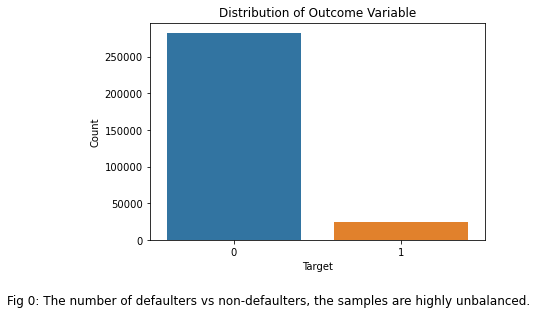

In [15]:
sns.countplot(data_drop_missing.TARGET)
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Distribution of Outcome Variable')
plt.figtext(0.4, -0.1, """Fig 0: The number of defaulters vs non-defaulters, the samples are highly unbalanced.""", 
            wrap = True, horizontalalignment = 'center', fontsize = 12)
plt.show()

#### Feature: FLOORSMAX_AVG / FLOORSMAX_MEDI / FLOORSMAX_MODE

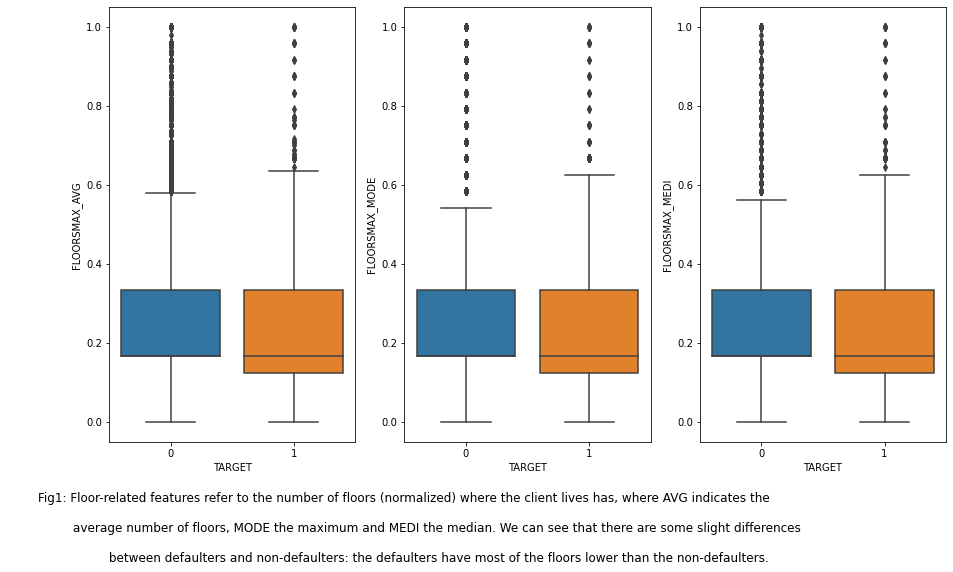

In [16]:
compare_boxplots(data_drop_missing, cols=col_collection['FLOORSMAX'], target='TARGET', if_text=True, 
                 txt="""Fig1: Floor-related features refer to the number of floors (normalized) where the client lives has, where AVG indicates the \n
                 average number of floors, MODE the maximum and MEDI the median. We can see that there are some slight differences \n
                 between defaulters and non-defaulters: the defaulters have most of the floors lower than the non-defaulters.""")

The distribution of the 3 predictors are basically the same with each other, we only keep one of them - the median.

In [17]:
drop_columns += ['FLOORSMAX_AVG', 'FLOORSMAX_MODE']
continuous_features.append('FLOORSMAX_MEDI')

#### Feature: YEARS_BEGINEXPLUATATION_AVG / YEARS_BEGINEXPLUATATION_MODE / YEARS_BEGINEXPLUATATION_MEDI

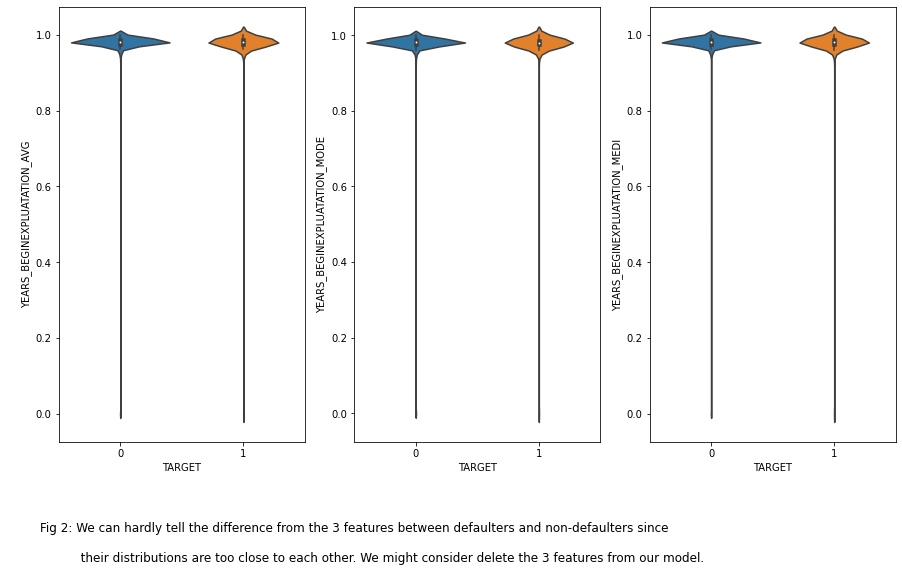

In [18]:
compare_violinplots(data_drop_missing, cols=col_collection['YEARS'], target='TARGET', if_text=True,
                   txt="""Fig 2: We can hardly tell the difference from the 3 features between defaulters and non-defaulters since \n
                   their distributions are too close to each other. We might consider delete the 3 features from our model.""")

In [19]:
# Since we can hardly tell the difference btween the defaulters and the non-defaulters given the predictors, the 3 features will be removed.
drop_columns += col_collection['YEARS']

#### Feature: TOTALAREA_MODE

In [20]:
data_drop_missing[[col_collection['TOTALAREA'][0]]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 1 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TOTALAREA_MODE  159080 non-null  float64
dtypes: float64(1)
memory usage: 2.3 MB


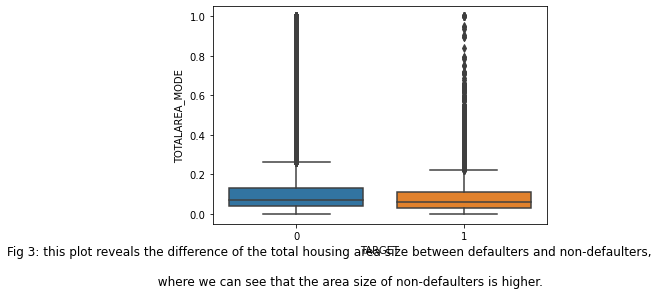

In [21]:
snsboxplot(data_drop_missing, col_collection['TOTALAREA'][0], 'TARGET', if_text=True, 
          txt="""Fig 3: this plot reveals the difference of the total housing area size between defaulters and non-defaulters, \n
          where we can see that the area size of non-defaulters is higher.""")

In [22]:
continuous_features.append('TOTALAREA_MODE')

#### Feature: EMERGENCYSTATE_MODE

In [23]:
data_drop_missing[[col_collection['EMERGENCYSTATE'][0]]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 1 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   EMERGENCYSTATE_MODE  161756 non-null  object
dtypes: object(1)
memory usage: 2.3+ MB


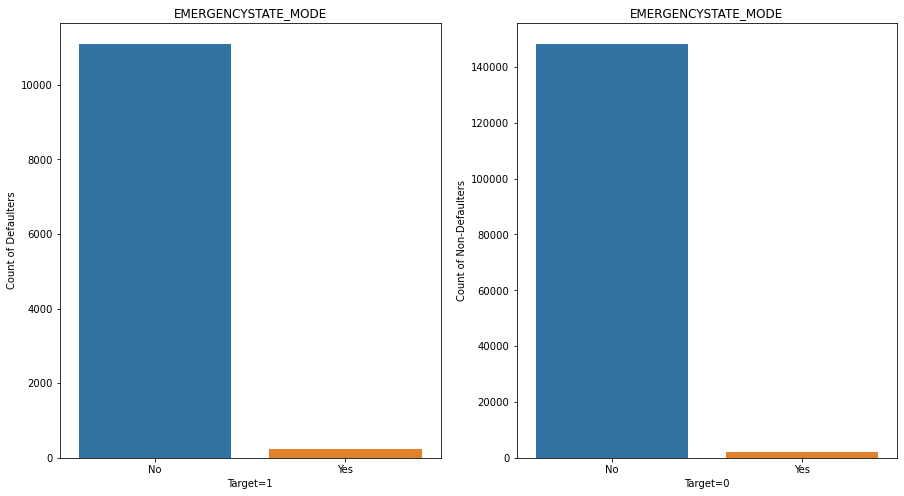

In [24]:
biplots(d1=defaulters, d2=non_defaulters, col=col_collection['EMERGENCYSTATE'][0])

In [25]:
categorical_features.append('EMERGENCYSTATE_MODE')

#### Feature: OCCUPATION TYPE

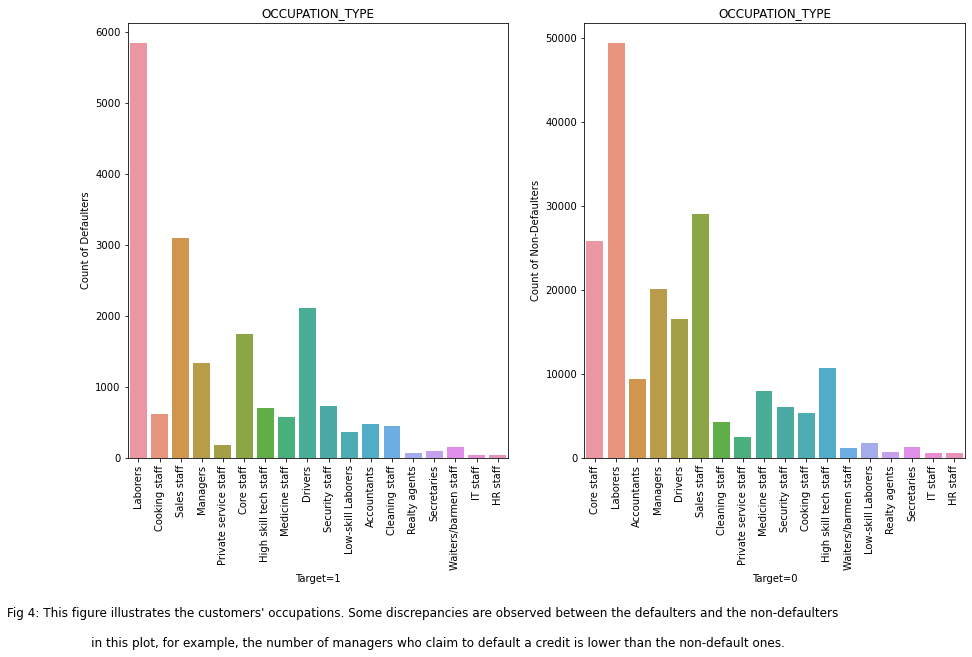

In [26]:
biplots(d1=defaulters, d2=non_defaulters, col=col_collection['OCCUPATION'][0], y=-0.2, rotate=True, fts=10, if_text=True,
       txt="""Fig 4: This figure illustrates the customers' occupations. Some discrepancies are observed between the defaulters and the non-defaulters \n
       in this plot, for example, the number of managers who claim to default a credit is lower than the non-default ones.""")

In [27]:
categorical_features += col_collection['OCCUPATION']

#### Feature: EXT SOURCE  2 / EXT SOURCE 3

In [28]:
col_collection['EXT']

['EXT_SOURCE_2', 'EXT_SOURCE_3']

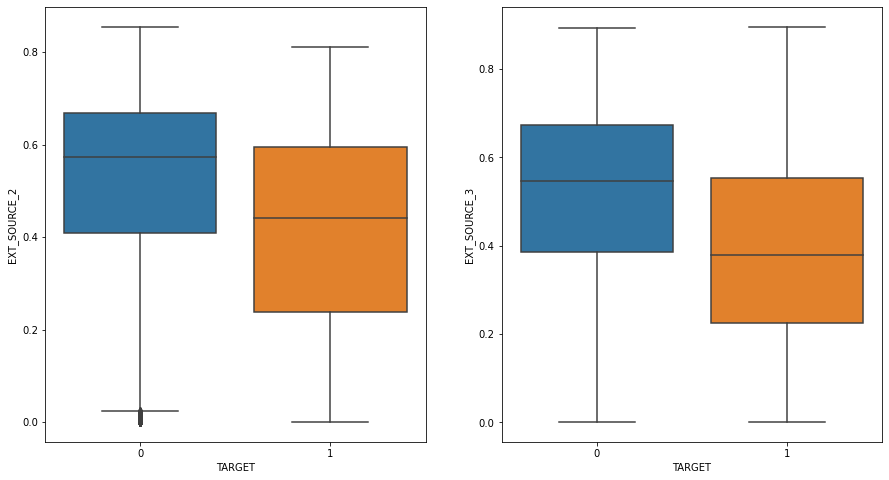

In [29]:
compare_boxplots(data_drop_missing, cols=col_collection['EXT'], target='TARGET')

In [30]:
continuous_features += col_collection['EXT']

#### Feature: AMT

In [31]:
col_collection['AMT']

['AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

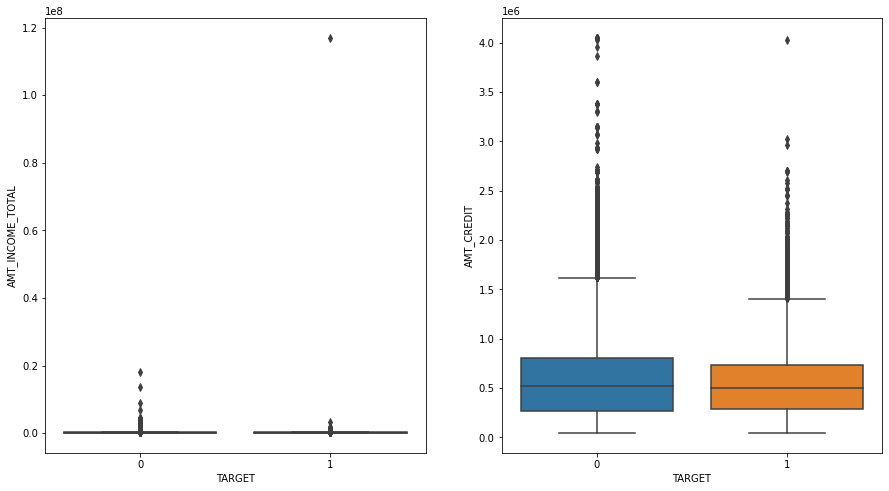

In [32]:
compare_boxplots(data_drop_missing, cols=col_collection['AMT'][0:2], target='TARGET')

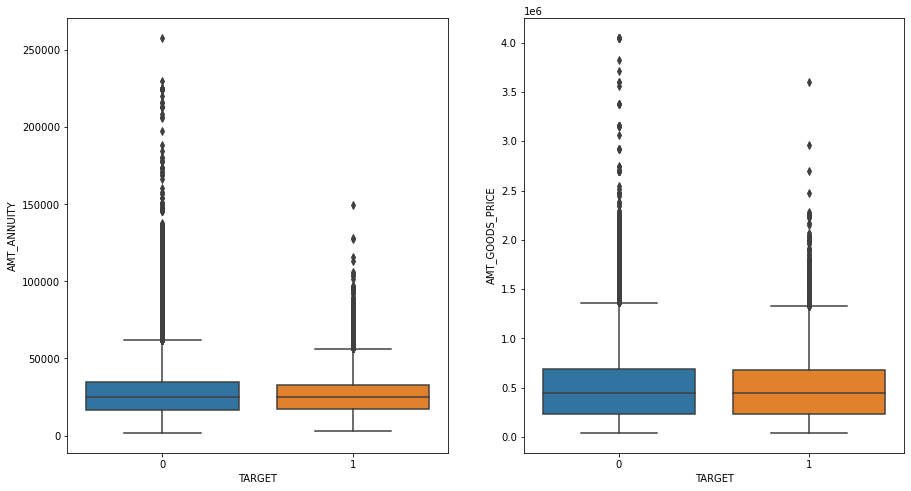

In [33]:
compare_boxplots(data_drop_missing, cols=col_collection['AMT'][2:4], target='TARGET')

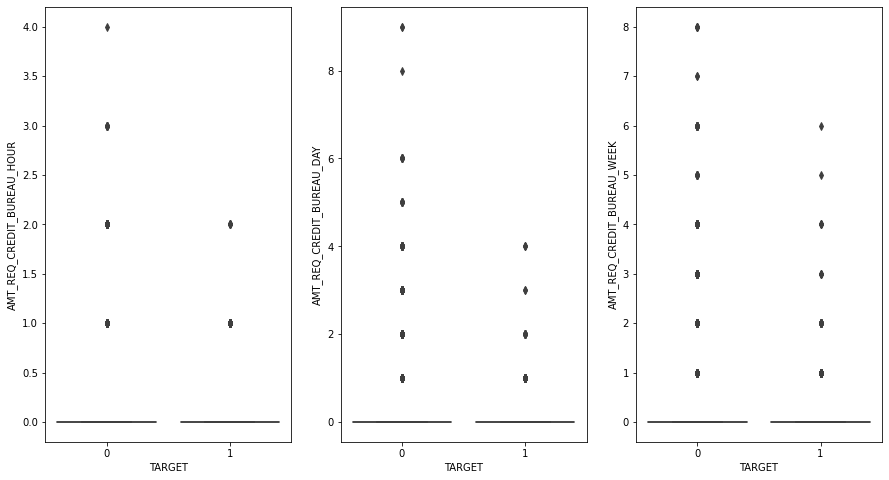

In [34]:
compare_boxplots(data_drop_missing, cols=col_collection['AMT'][4:7], target='TARGET')

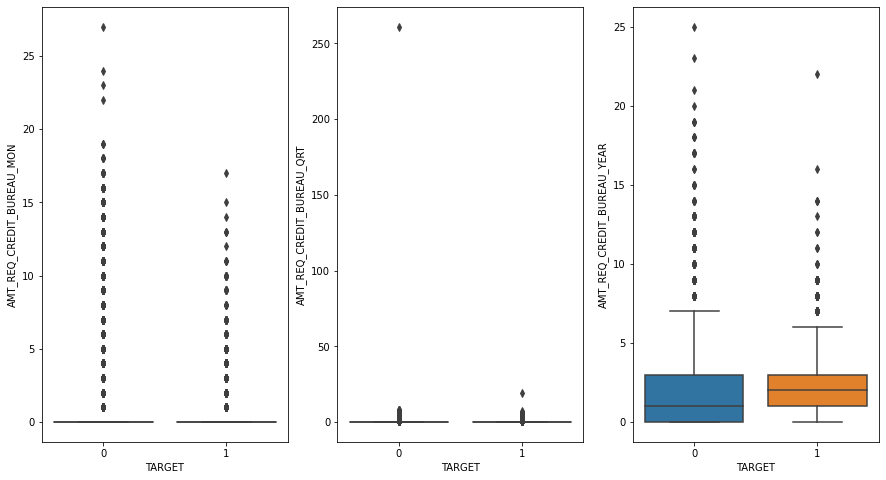

In [35]:
compare_boxplots(data_drop_missing, cols=col_collection['AMT'][7:10], target='TARGET')

In [36]:
drop_columns += ['AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT']
continuous_features += ['AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

#### Feature: NAME_CONTRACT_TYPE / NAME_TYPE_SUITE / NAME_INCOME_TYPE / NAME_EDUCATION_TYPE / NAME_FAMILY_STATUS / NAME_HOUSING_TYPE

In [37]:
data_drop_missing[col_collection['NAME']].dtypes

NAME_CONTRACT_TYPE     object
NAME_TYPE_SUITE        object
NAME_INCOME_TYPE       object
NAME_EDUCATION_TYPE    object
NAME_FAMILY_STATUS     object
NAME_HOUSING_TYPE      object
dtype: object

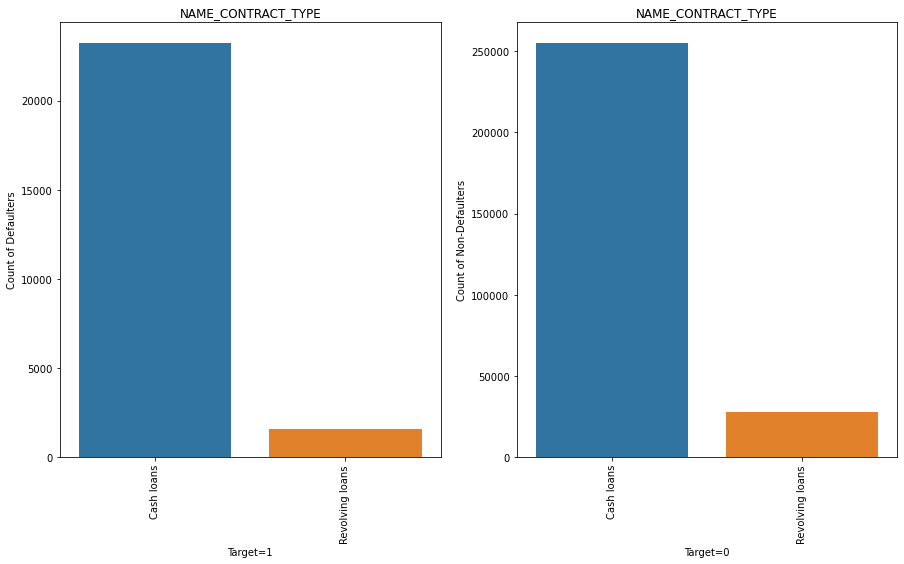

In [38]:
biplots(d1=defaulters, d2=non_defaulters, col='NAME_CONTRACT_TYPE', rotate=True, fts=10)

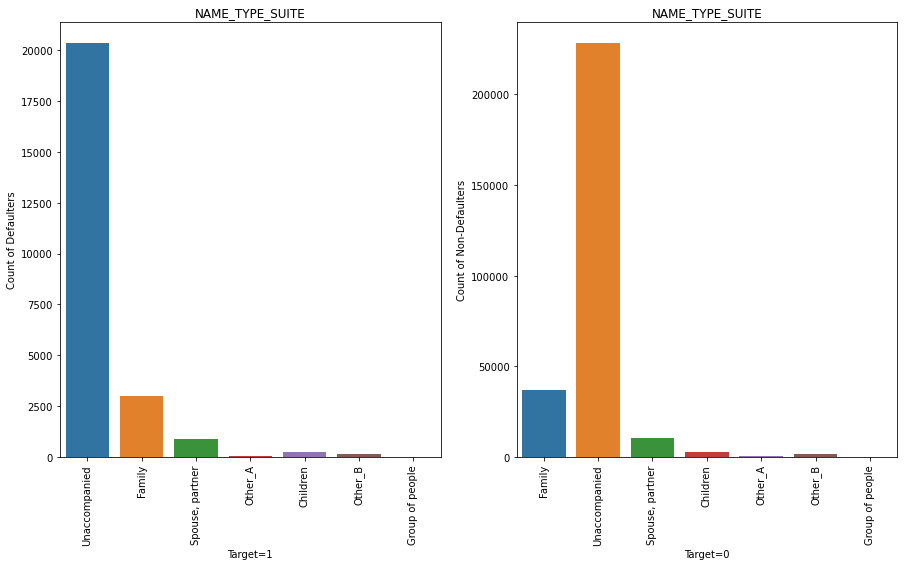

In [39]:
biplots(d1=defaulters, d2=non_defaulters, col='NAME_TYPE_SUITE', rotate=True, fts=10)

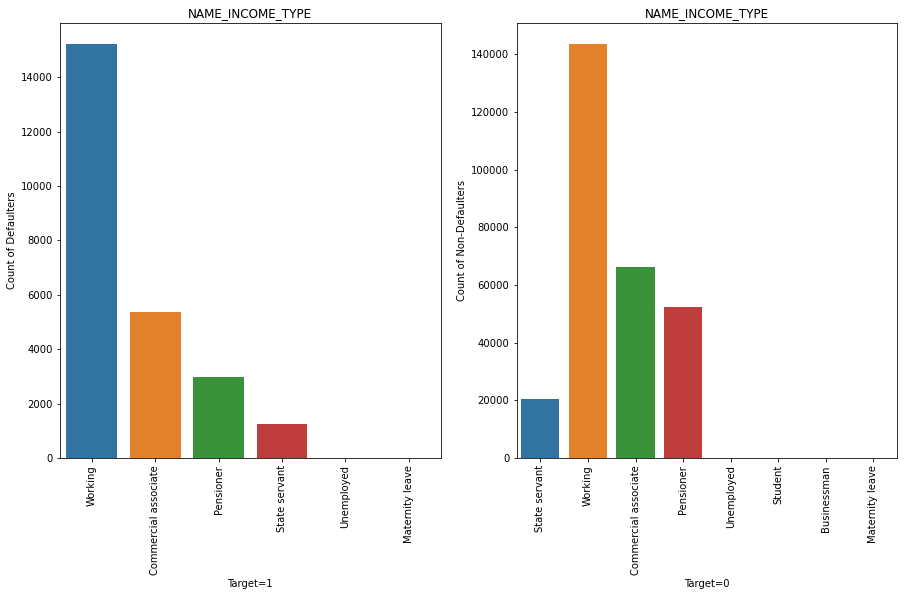

In [40]:
biplots(d1=defaulters, d2=non_defaulters, col='NAME_INCOME_TYPE', rotate=True, fts=10)

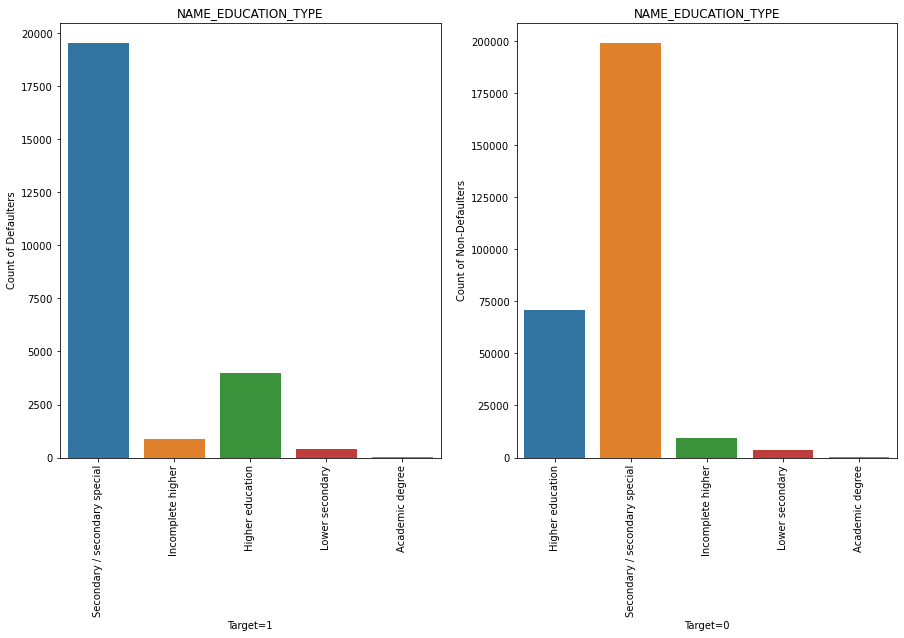

In [41]:
biplots(d1=defaulters, d2=non_defaulters, col='NAME_EDUCATION_TYPE', rotate=True, fts=10)

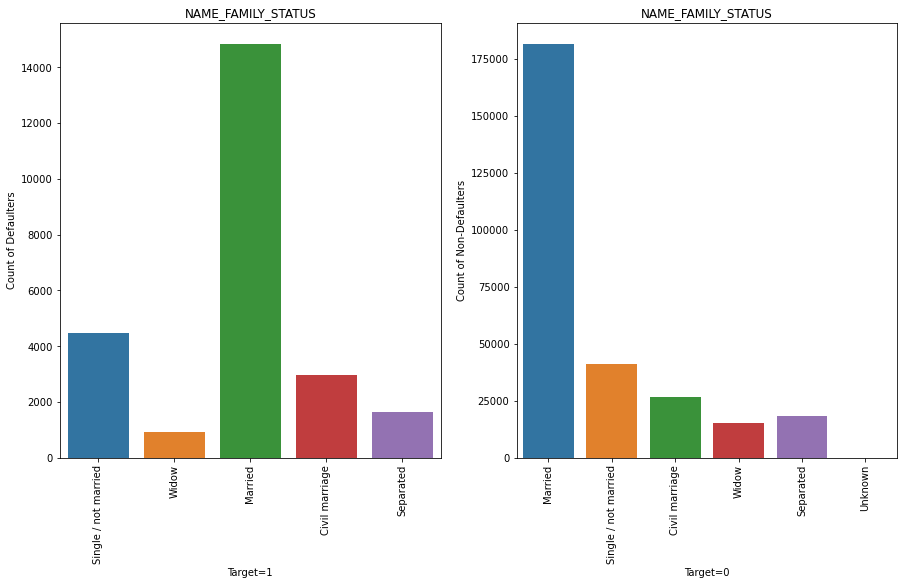

In [42]:
biplots(d1=defaulters, d2=non_defaulters, col='NAME_FAMILY_STATUS', rotate=True, fts=10)

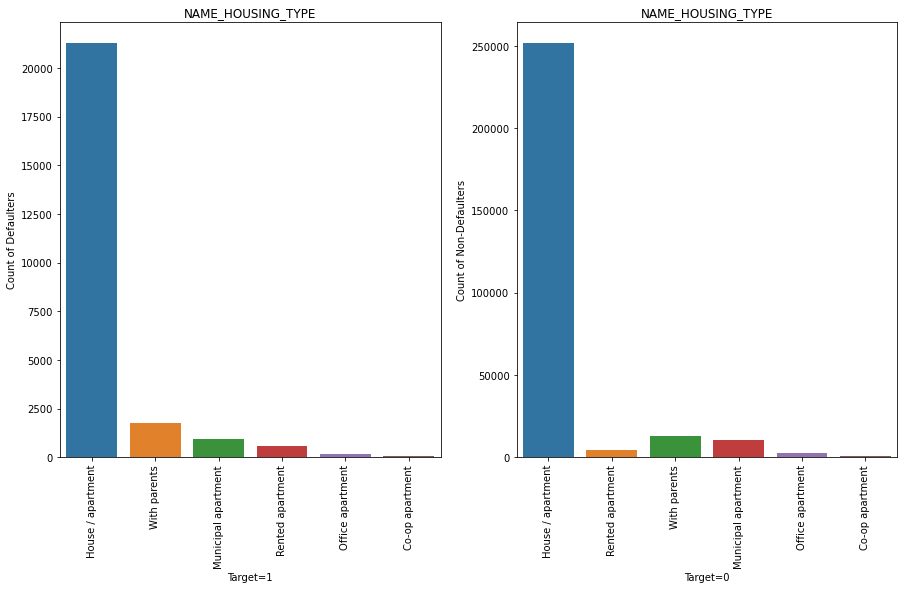

In [43]:
biplots(d1=defaulters, d2=non_defaulters, col='NAME_HOUSING_TYPE', rotate=True, fts=10)

In [44]:
categorical_features += col_collection['NAME']

#### CNT: CNT_FAM_MEMBERS

In [45]:
col_collection['CNT']

['CNT_CHILDREN', 'CNT_FAM_MEMBERS']

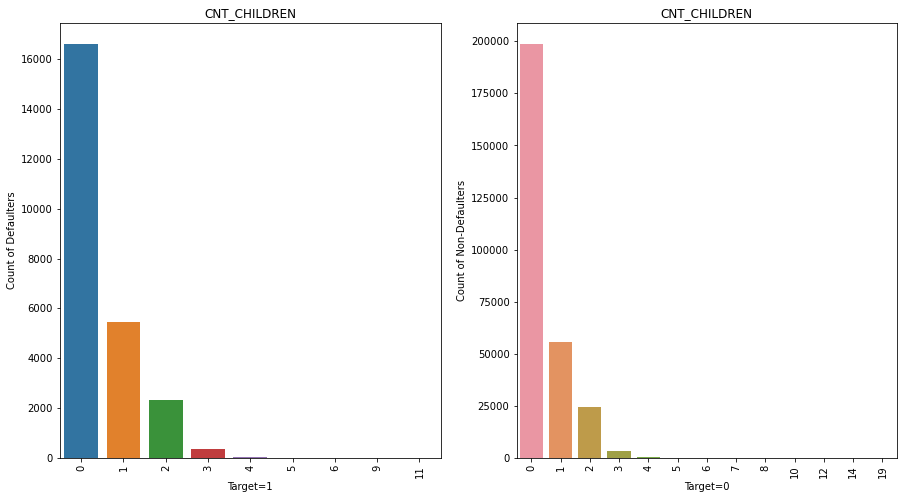

In [46]:
biplots(d1=defaulters, d2=non_defaulters, col='CNT_CHILDREN', rotate=True, fts=10)

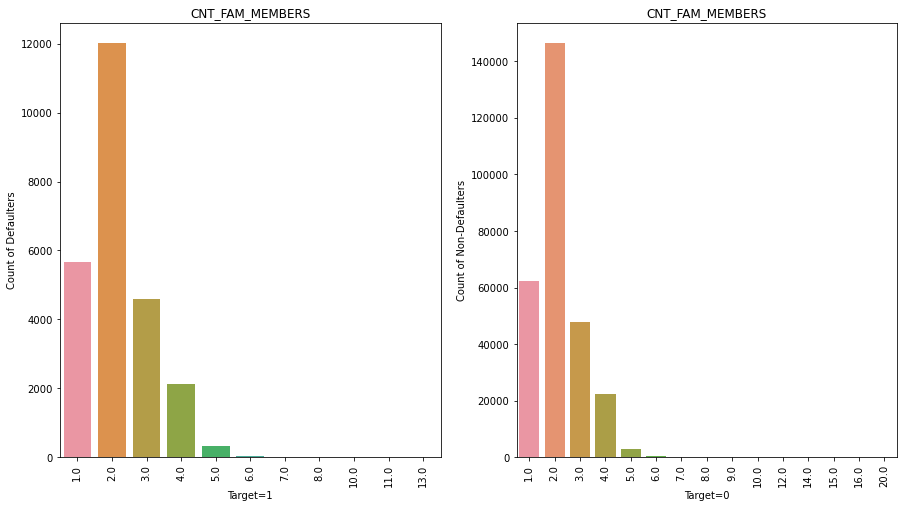

In [47]:
biplots(d1=defaulters, d2=non_defaulters, col='CNT_FAM_MEMBERS', rotate=True, fts=10)

In [48]:
continuous_features += col_collection['CNT']

#### Feature: DAYS_BIRTH / DAYS_EMPLOYED / DAYS_REGISTRATION / DAYS_ID_PUBLISH / DAYS_LAST_PHONE_CHANGE

In [49]:
' / '.join(col_collection['DAYS'])

'DAYS_BIRTH / DAYS_EMPLOYED / DAYS_REGISTRATION / DAYS_ID_PUBLISH / DAYS_LAST_PHONE_CHANGE'

In [50]:
data_drop_missing[col_collection['DAYS']].head()

,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE
0,-9461,-637,-3648.0,-2120,-1134.0
1,-16765,-1188,-1186.0,-291,-828.0
2,-19046,-225,-4260.0,-2531,-815.0
3,-19005,-3039,-9833.0,-2437,-617.0
4,-19932,-3038,-4311.0,-3458,-1106.0


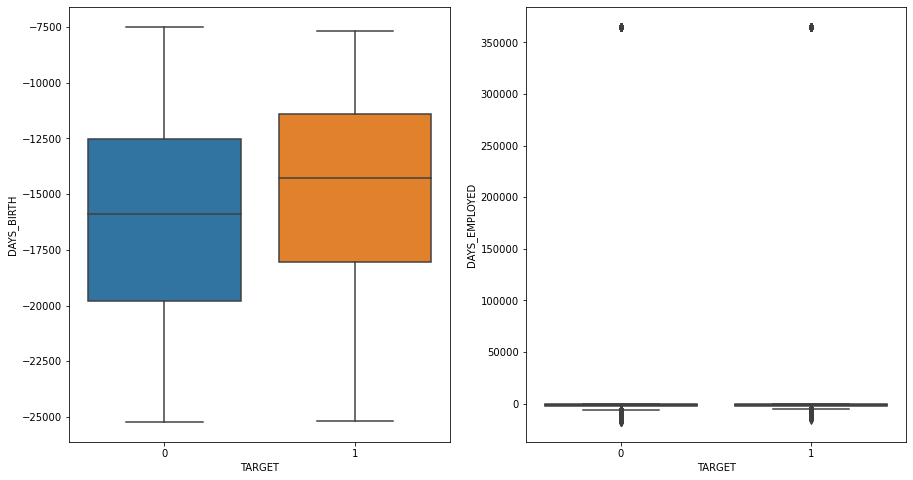

In [51]:
compare_boxplots(d=data_drop_missing, cols=col_collection['DAYS'][0:2], target='TARGET', fig_size=(15, 8))

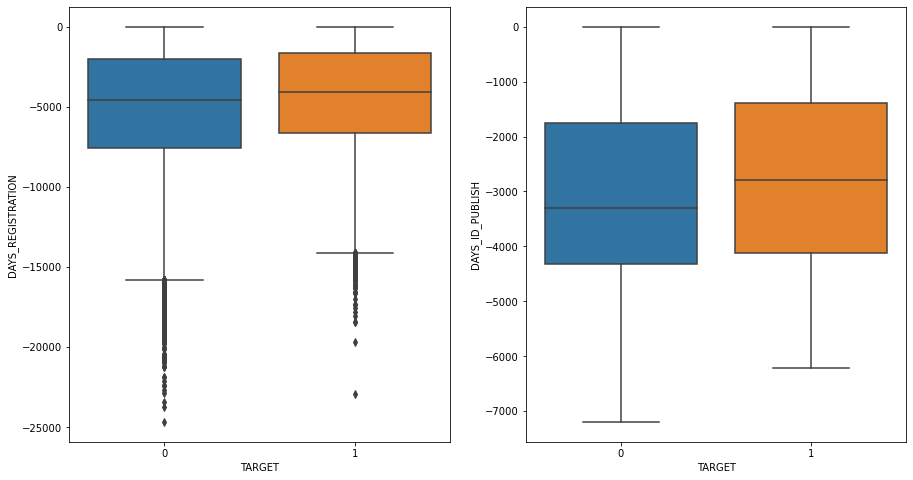

In [52]:
compare_boxplots(d=data_drop_missing, cols=col_collection['DAYS'][2:4], target='TARGET', fig_size=(15, 8))

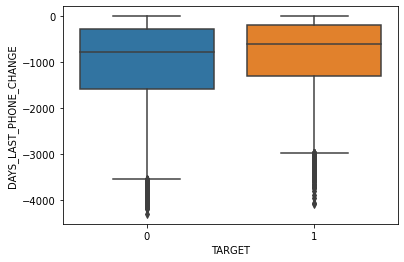

In [53]:
snsboxplot(d=data_drop_missing, col=col_collection['DAYS'][4], target='TARGET')

In [54]:
continuous_features += col_collection['DAYS']

#### Feature: FLAG - bool type features

In [55]:
col_collection['FLAG']

['FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21']

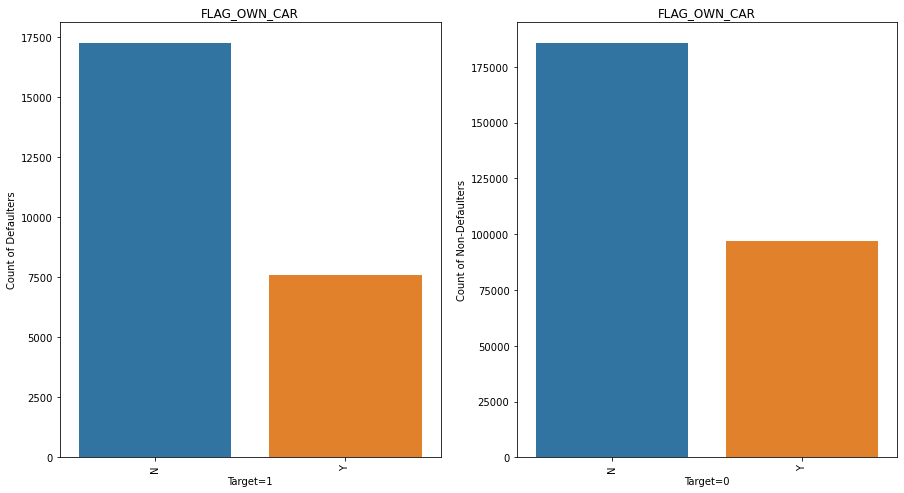

In [56]:
biplots(d1=defaulters, d2=non_defaulters, col='FLAG_OWN_CAR', rotate=True, fts=10)

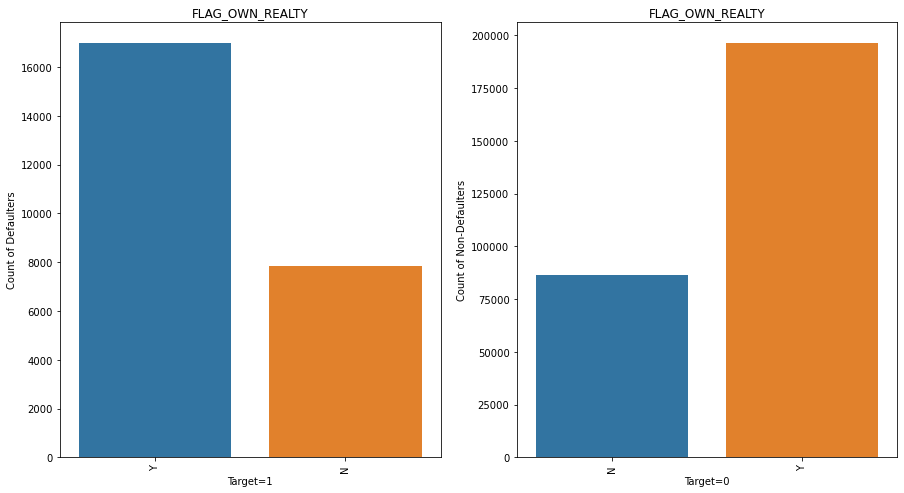

In [57]:
biplots(d1=defaulters, d2=non_defaulters, col='FLAG_OWN_REALTY', rotate=True, fts=10)

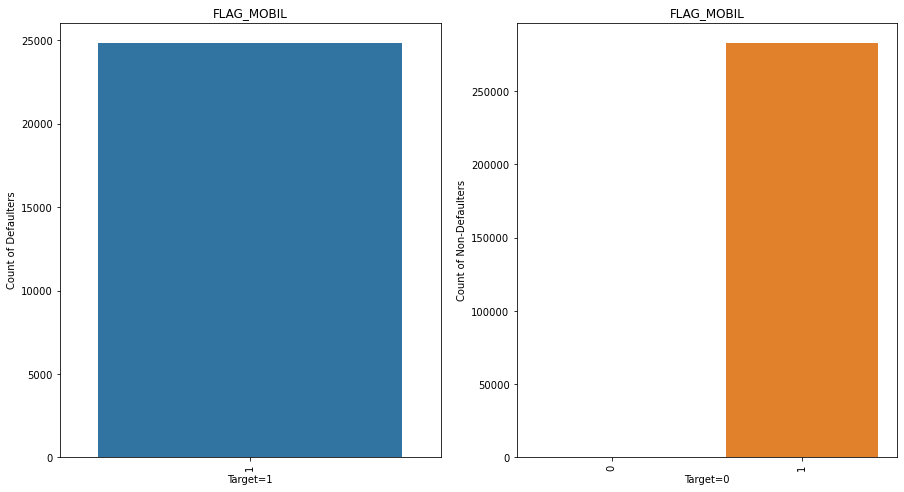

In [58]:
biplots(d1=defaulters, d2=non_defaulters, col='FLAG_MOBIL', rotate=True, fts=10)

This should be dropped due to its non-informativeness.

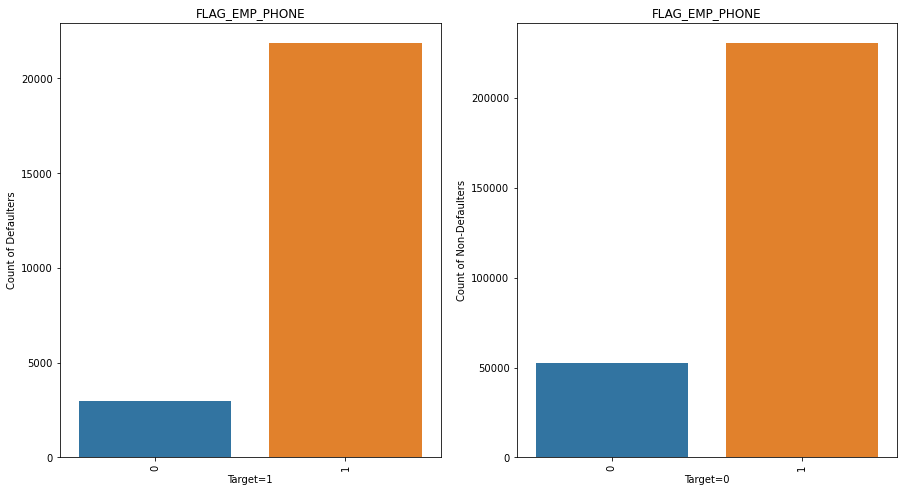

In [59]:
biplots(d1=defaulters, d2=non_defaulters, col='FLAG_EMP_PHONE', rotate=True, fts=10)

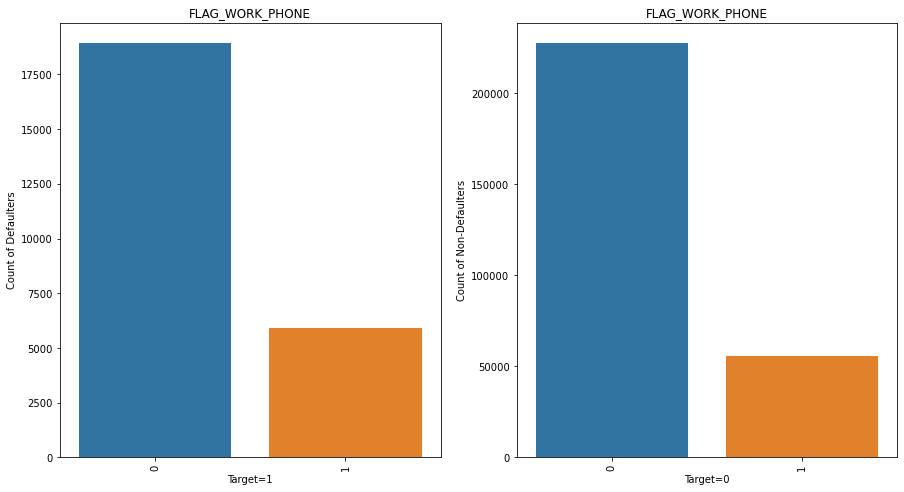

In [60]:
biplots(d1=defaulters, d2=non_defaulters, col='FLAG_WORK_PHONE', rotate=True, fts=10)

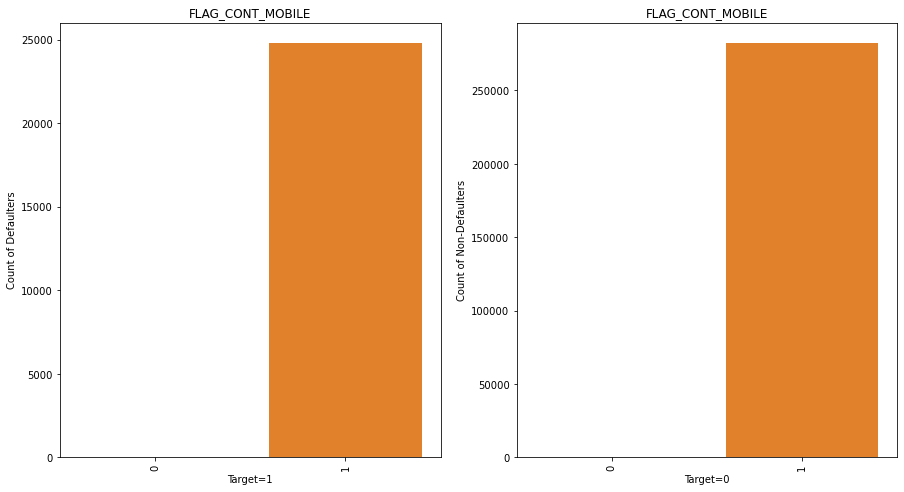

In [61]:
biplots(d1=defaulters, d2=non_defaulters, col='FLAG_CONT_MOBILE', rotate=True, fts=10)

This should be dropped due to its non-informativeness.

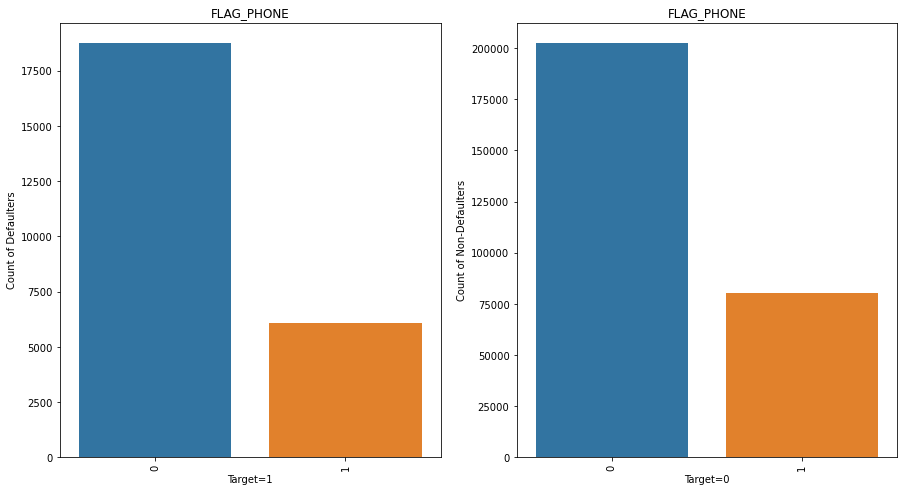

In [62]:
biplots(d1=defaulters, d2=non_defaulters, col='FLAG_PHONE', rotate=True, fts=10)

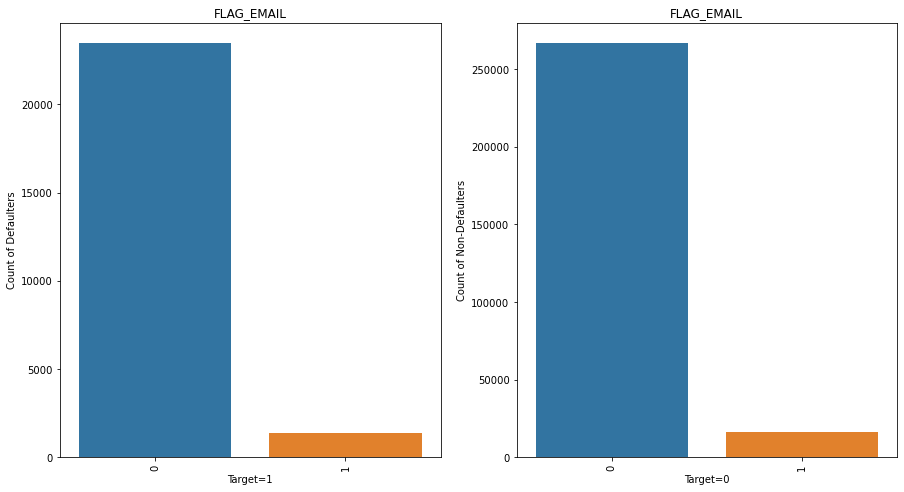

In [63]:
biplots(d1=defaulters, d2=non_defaulters, col='FLAG_EMAIL', rotate=True, fts=10)

For the bool values to decide whether a document is submitted, we simply give the count of defaulters vs non-defaulters.

In [64]:
for col in [x for x in col_collection['FLAG'] if 'DOCUMENT' in x]:
    print('Defaulter: \n', defaulters[col].value_counts())
    print('Non-Defaulter: \n', non_defaulters[col].value_counts())
    print('\n')

Defaulter: 
 0    24821
1        4
Name: FLAG_DOCUMENT_2, dtype: int64
Non-Defaulter: 
 0    282677
1         9
Name: FLAG_DOCUMENT_2, dtype: int64


Defaulter: 
 1    19312
0     5513
Name: FLAG_DOCUMENT_3, dtype: int64
Non-Defaulter: 
 1    199028
0     83658
Name: FLAG_DOCUMENT_3, dtype: int64


Defaulter: 
 0    24825
Name: FLAG_DOCUMENT_4, dtype: int64
Non-Defaulter: 
 0    282661
1        25
Name: FLAG_DOCUMENT_4, dtype: int64


Defaulter: 
 0    24453
1      372
Name: FLAG_DOCUMENT_5, dtype: int64
Non-Defaulter: 
 0    278410
1      4276
Name: FLAG_DOCUMENT_5, dtype: int64


Defaulter: 
 0    23318
1     1507
Name: FLAG_DOCUMENT_6, dtype: int64
Non-Defaulter: 
 0    257115
1     25571
Name: FLAG_DOCUMENT_6, dtype: int64


Defaulter: 
 0    24822
1        3
Name: FLAG_DOCUMENT_7, dtype: int64
Non-Defaulter: 
 0    282630
1        56
Name: FLAG_DOCUMENT_7, dtype: int64


Defaulter: 
 0    22989
1     1836
Name: FLAG_DOCUMENT_8, dtype: int64
Non-Defaulter: 
 0    259498
1     23188

In [65]:
drop_columns += ['FLAG_CONT_MOBILE', 'FLAG_MOBIL']
categorical_features += [x for x in col_collection['FLAG'] if x not in ['FLAG_CONT_MOBILE', 'FLAG_MOBIL']]

#### Features: REGION-related

In [66]:
col_collection['REGION']

['REGION_POPULATION_RELATIVE',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY']

In [67]:
data_drop_missing[col_collection['REGION']].dtypes

REGION_POPULATION_RELATIVE     float64
REGION_RATING_CLIENT             int64
REGION_RATING_CLIENT_W_CITY      int64
dtype: object

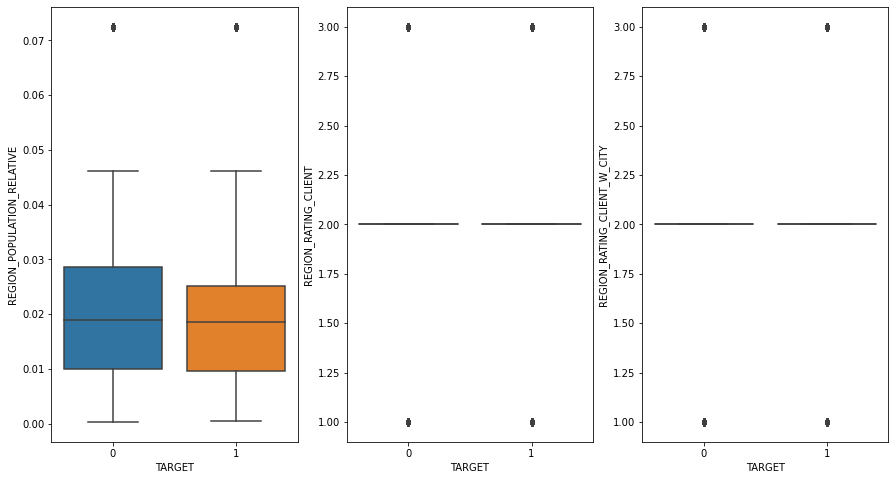

In [68]:
compare_boxplots(data_drop_missing, col_collection['REGION'], 'TARGET')

In [69]:
ordinal_features += col_collection['REGION'][1:]
continuous_features += [col_collection['REGION'][0]]

#### Feature: CODE_GENDER

In [70]:
col_collection['CODE']

['CODE_GENDER']

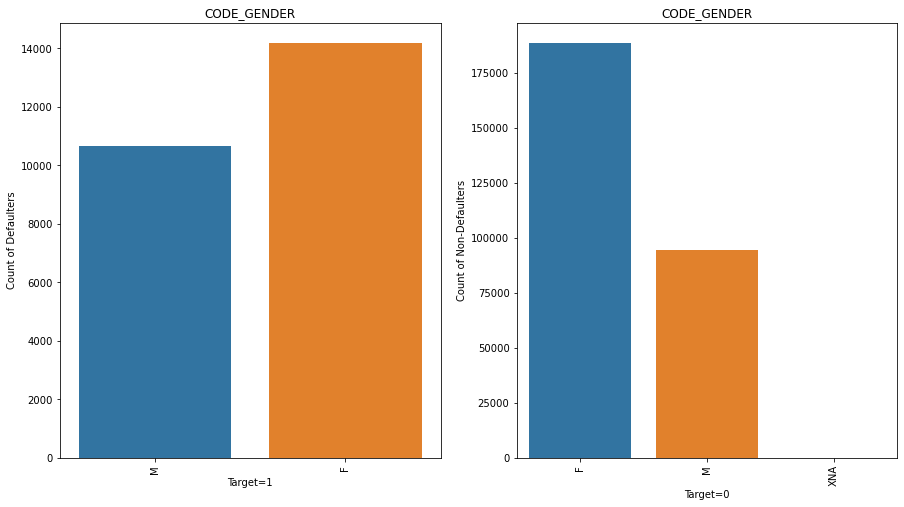

In [71]:
biplots(d1=defaulters, d2=non_defaulters, col='CODE_GENDER', rotate=True, fts=10)

In [72]:
categorical_features.append('CODE_GENDER')

#### Feature: ORGANIZATION

In [73]:
col_collection['ORGANIZATION']

['ORGANIZATION_TYPE']

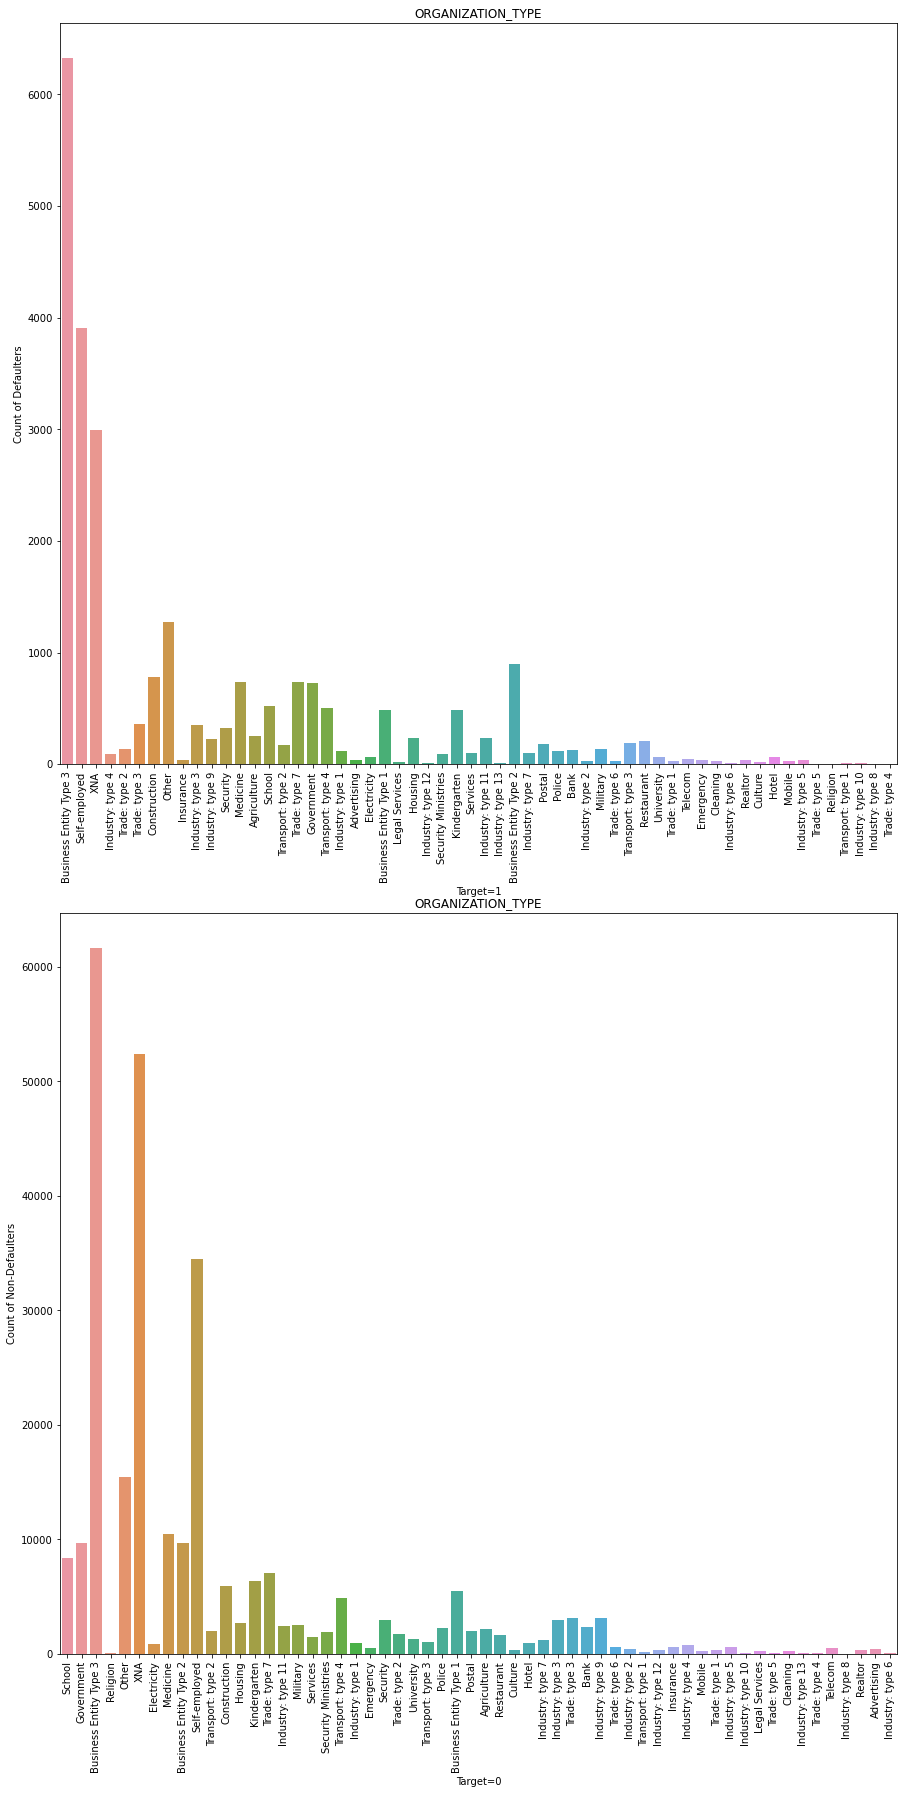

In [74]:
biplots(d1=defaulters, d2=non_defaulters, col='ORGANIZATION_TYPE', rotate=True, fts=10, nr=2, nc=1, fs=(15, 30))

In [75]:
categorical_features += col_collection['ORGANIZATION']

#### Feature: LIVE CITY / REG CITY

In [76]:
categorical_features += col_collection['LIVE'] + col_collection['REG']

#### Feature: HOUR_APPR_PROCESS_START

In [77]:
col_collection['HOUR']

['HOUR_APPR_PROCESS_START']

In [78]:
data_drop_missing[col_collection['HOUR']].describe()

,HOUR_APPR_PROCESS_START
count,307511.000000
mean,12.063419
std,3.265832
min,0.000000
25%,10.000000
50%,12.000000
75%,14.000000
max,23.000000


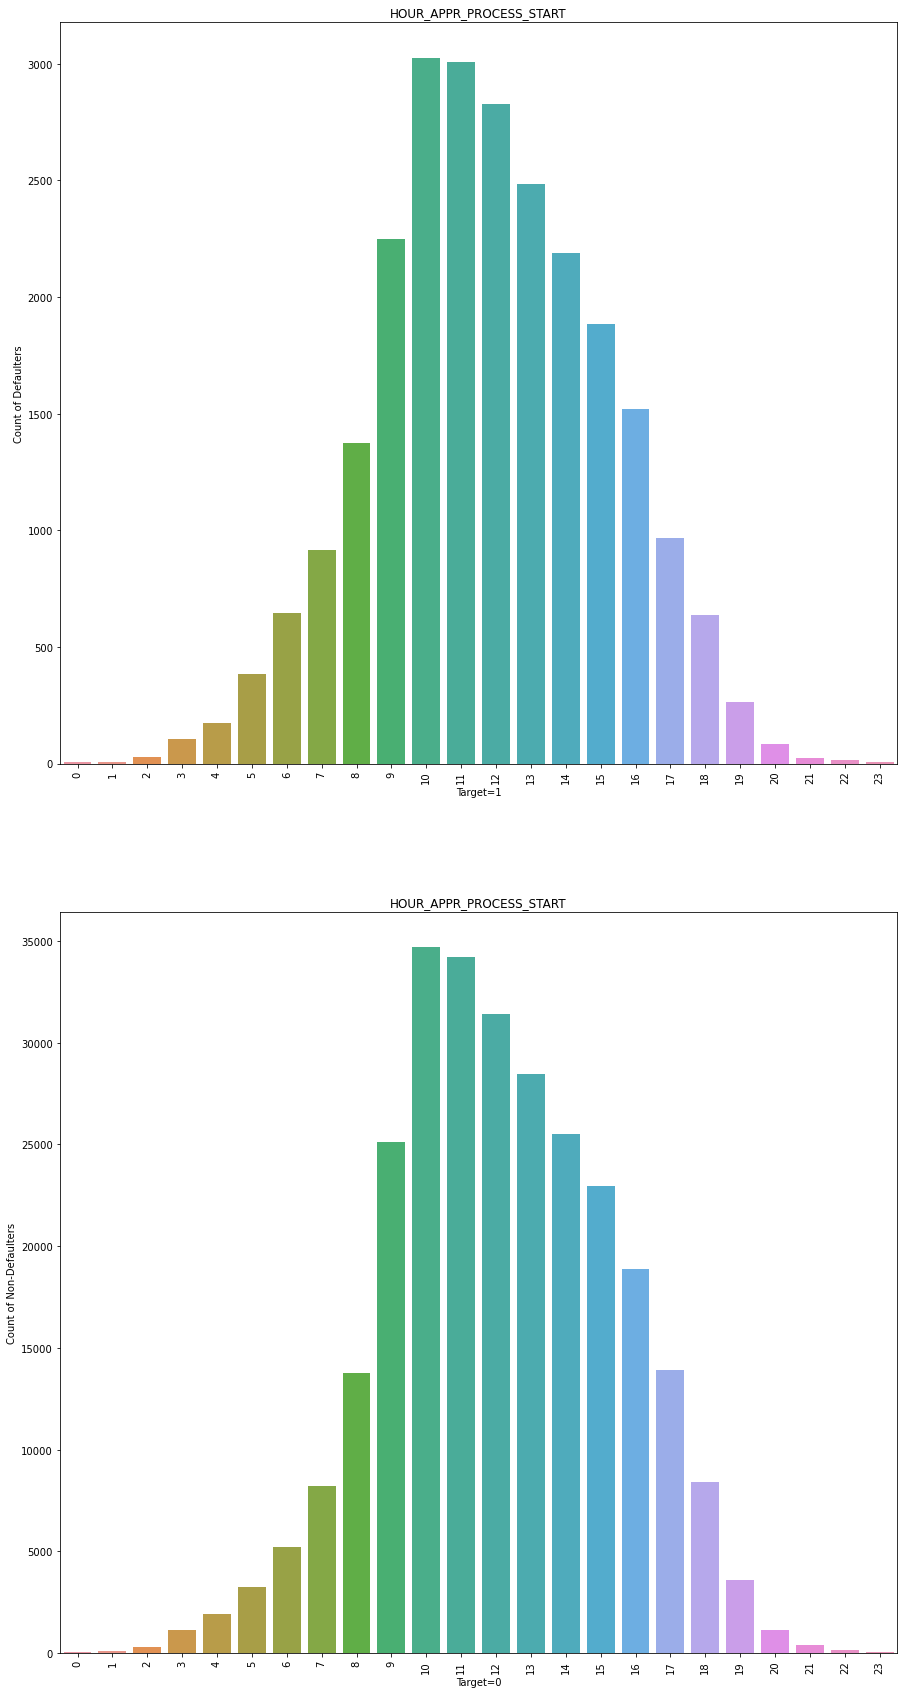

In [79]:
biplots(d1=defaulters, d2=non_defaulters, col=col_collection['HOUR'][0], rotate=True, fts=10, nr=2, nc=1, fs=(15, 30))

In [80]:
ordinal_features += col_collection['HOUR']

#### Feature: WEEKDAY_APPR_PROCESS_START

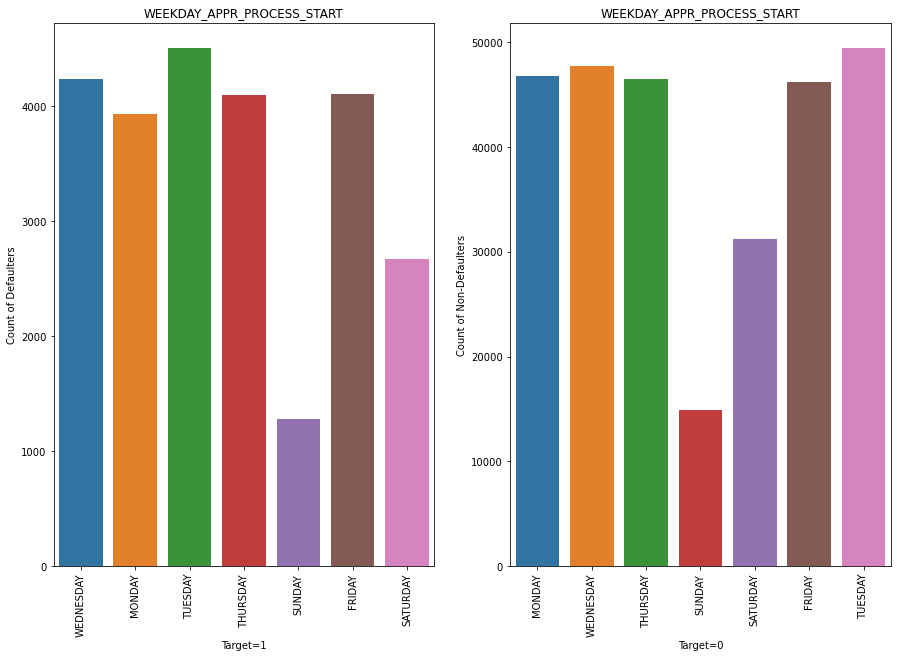

In [81]:
biplots(d1=defaulters, d2=non_defaulters, col=col_collection['WEEKDAY'][0], rotate=True, fts=10, nr=1, nc=2, fs=(15, 10))

In [82]:
ordinal_features += col_collection['WEEKDAY']

#### Feature: SK_ID_CURR

In [83]:
# drop
drop_columns += ['SK_ID_CURR']

#### Brief look on features:

In [84]:
continuous_features

['FLOORSMAX_MEDI',
 'TOTALAREA_MODE',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'CNT_CHILDREN',
 'CNT_FAM_MEMBERS',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE',
 'REGION_POPULATION_RELATIVE']

In [85]:
len(continuous_features)

17

In [86]:
categorical_features

['EMERGENCYSTATE_MODE',
 'OCCUPATION_TYPE',
 'NAME_CONTRACT_TYPE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21',
 'CODE_GENDER',
 'ORGANIZATION_TYPE',
 'LIVE_REGION_NOT_WORK_REGION',
 'LIVE_CITY_NOT_WORK_CITY',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY']

In [87]:
ordinal_features

['REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'WEEKDAY_APPR_PROCESS_START']

In [88]:
drop_columns

['FLOORSMAX_AVG',
 'FLOORSMAX_MODE',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'FLAG_CONT_MOBILE',
 'FLAG_MOBIL',
 'SK_ID_CURR']

#### Scatter plot of float-type features

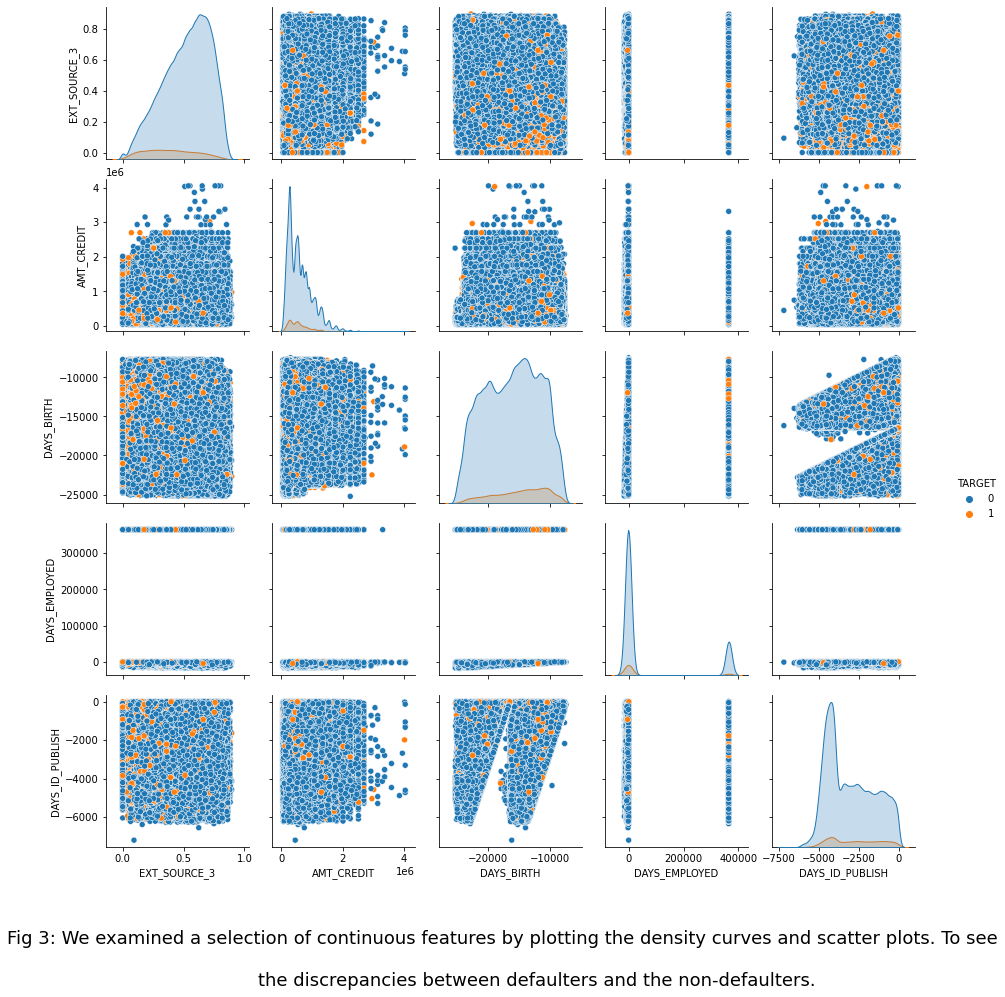

In [30]:
sns.pairplot(data_drop_missing[['EXT_SOURCE_3',
 'AMT_CREDIT',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_ID_PUBLISH', 'TARGET']], hue='TARGET')
plt.figtext(0.5, -0.1, 
            """Fig 3: We examined a selection of continuous features by plotting the density curves and scatter plots. To see\n
            the discrepancies between defaulters and the non-defaulters.""", 
            wrap=True, horizontalalignment='center', fontsize=18)
plt.show()

#### Missing Value Handling

In [90]:
data_drop_missing[categorical_features].isnull().sum()/len(data_drop_missing)

EMERGENCYSTATE_MODE            0.473983
OCCUPATION_TYPE                0.313455
NAME_CONTRACT_TYPE             0.000000
NAME_TYPE_SUITE                0.004201
NAME_INCOME_TYPE               0.000000
NAME_EDUCATION_TYPE            0.000000
NAME_FAMILY_STATUS             0.000000
NAME_HOUSING_TYPE              0.000000
FLAG_OWN_CAR                   0.000000
FLAG_OWN_REALTY                0.000000
FLAG_EMP_PHONE                 0.000000
FLAG_WORK_PHONE                0.000000
FLAG_PHONE                     0.000000
FLAG_EMAIL                     0.000000
FLAG_DOCUMENT_2                0.000000
FLAG_DOCUMENT_3                0.000000
FLAG_DOCUMENT_4                0.000000
FLAG_DOCUMENT_5                0.000000
FLAG_DOCUMENT_6                0.000000
FLAG_DOCUMENT_7                0.000000
FLAG_DOCUMENT_8                0.000000
FLAG_DOCUMENT_9                0.000000
FLAG_DOCUMENT_10               0.000000
FLAG_DOCUMENT_11               0.000000
FLAG_DOCUMENT_12               0.000000


In [91]:
data_drop_missing['OCCUPATION_TYPE'].value_counts()

Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: OCCUPATION_TYPE, dtype: int64

For occupation type, we will impute missing value as "Other".

In [92]:
data_drop_missing['OCCUPATION_TYPE'] = data_drop_missing['OCCUPATION_TYPE'].fillna('Other')

<ipython-input-92-39d7826e018f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_drop_missing['OCCUPATION_TYPE'] = data_drop_missing['OCCUPATION_TYPE'].fillna('Other')


In [93]:
data_drop_missing['EMERGENCYSTATE_MODE'].value_counts()

No     159428
Yes      2328
Name: EMERGENCYSTATE_MODE, dtype: int64

We will fill the missing ones with "unknown".

In [94]:
data_drop_missing['EMERGENCYSTATE_MODE'] = data_drop_missing['EMERGENCYSTATE_MODE'].fillna('Unknown')

<ipython-input-94-482971aa9115>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_drop_missing['EMERGENCYSTATE_MODE'] = data_drop_missing['EMERGENCYSTATE_MODE'].fillna('Unknown')


For 'NAME_TYPE_SUITE', we just throw away the empty ones.

In [95]:
data_drop_missing = data_drop_missing.loc[-data_drop_missing['NAME_TYPE_SUITE'].isnull(), :].reset_index(drop=True)

In [96]:
data_drop_missing[categorical_features].isnull().sum()/len(data_drop_missing)

EMERGENCYSTATE_MODE            0.0
OCCUPATION_TYPE                0.0
NAME_CONTRACT_TYPE             0.0
NAME_TYPE_SUITE                0.0
NAME_INCOME_TYPE               0.0
NAME_EDUCATION_TYPE            0.0
NAME_FAMILY_STATUS             0.0
NAME_HOUSING_TYPE              0.0
FLAG_OWN_CAR                   0.0
FLAG_OWN_REALTY                0.0
FLAG_EMP_PHONE                 0.0
FLAG_WORK_PHONE                0.0
FLAG_PHONE                     0.0
FLAG_EMAIL                     0.0
FLAG_DOCUMENT_2                0.0
FLAG_DOCUMENT_3                0.0
FLAG_DOCUMENT_4                0.0
FLAG_DOCUMENT_5                0.0
FLAG_DOCUMENT_6                0.0
FLAG_DOCUMENT_7                0.0
FLAG_DOCUMENT_8                0.0
FLAG_DOCUMENT_9                0.0
FLAG_DOCUMENT_10               0.0
FLAG_DOCUMENT_11               0.0
FLAG_DOCUMENT_12               0.0
FLAG_DOCUMENT_13               0.0
FLAG_DOCUMENT_14               0.0
FLAG_DOCUMENT_15               0.0
FLAG_DOCUMENT_16    

In [97]:
data_drop_missing[ordinal_features].isnull().sum()/len(data_drop_missing)

REGION_RATING_CLIENT           0.0
REGION_RATING_CLIENT_W_CITY    0.0
HOUR_APPR_PROCESS_START        0.0
WEEKDAY_APPR_PROCESS_START     0.0
dtype: float64

In [98]:
data_drop_missing[continuous_features].isnull().sum()/len(data_drop_missing)

FLOORSMAX_MEDI                0.497752
TOTALAREA_MODE                0.482831
EXT_SOURCE_2                  0.002152
EXT_SOURCE_3                  0.198391
AMT_INCOME_TOTAL              0.000000
AMT_CREDIT                    0.000000
AMT_ANNUITY                   0.000039
AMT_GOODS_PRICE               0.000000
AMT_REQ_CREDIT_BUREAU_YEAR    0.135230
CNT_CHILDREN                  0.000000
CNT_FAM_MEMBERS               0.000000
DAYS_BIRTH                    0.000000
DAYS_EMPLOYED                 0.000000
DAYS_REGISTRATION             0.000000
DAYS_ID_PUBLISH               0.000000
DAYS_LAST_PHONE_CHANGE        0.000003
REGION_POPULATION_RELATIVE    0.000000
dtype: float64

For the missing values in continuous features, we will use KNN method to do the imputation.

#### Splitting the data into 3 subsets

In [99]:
selected_features = continuous_features + categorical_features + ordinal_features

In [100]:
print('In all {} features are selected. {} observations.'.format(len(selected_features), data_drop_missing.shape[0]))

In all 63 features are selected. 306219 observations.


In [101]:
imp_iterative = IterativeImputer(random_state=RANDOM_SEED)
imp_iterative.fit(data_drop_missing[continuous_features])
data_drop_missing.loc[:, continuous_features] = imp_iterative.transform(data_drop_missing[continuous_features])

In [183]:
smote = SMOTE()
x, y = smote.fit(data_drop_missing.drop(columns=['TARGET']), data_drop_missing['TARGET'])
x[:, 10]

ValueError: could not convert string to float: 'Cash loans'

In [182]:
data_drop_missing[selected_features + ['TARGET']].to_csv('/Users/bangxixiao/Desktop/python_projects/DATA1030_MIDTERM_PROJECT/data/data_imputed.csv',
                                                        index=False)


